<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PEC2</p>
<p style="margin: 0; text-align:right;">2022-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 2: Redes neuronales recurrentes con Keras

A lo largo de esta práctica vamos a implementar varios modelos de redes neuronales recurrentes para la detección, clasificación y localización de errores en datos temporales producidos por varios sensores. 

<u>Consideraciones generales</u>: 

- Esta PEC debe realizarse de forma **estrictamente individual**. Cualquier indicio de copia será penalizado con un suspenso (D) para todas las partes implicadas y la posible evaluación negativa de la asignatura de forma íntegra.
- Es necesario que el estudiante indique **todas las fuentes** que ha utilizado para la realización de la PEC. De no ser así, se considerará que el estudiante ha cometido plagio, siendo penalizado con un suspenso (D) y la posible evaluación negativa de la asignatura de forma íntegra.

<u>Formato de la entrega</u>:

- Algunos ejercicios pueden suponer varios minutos de ejecución, por lo que la entrega debe hacerse en **formato notebook** y en **formato html**, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a HTML desde el menú File $\to$ Download as $\to$ HTML.
- Existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de la actividad. Para cambiar el tipo de celda a este tipo, en el menú: Cell $\to$ Cell Type $\to$ Markdown.

# 0. Contexto y carga de librerias

En esta PEC vamos a utilizar redes recurrentes para trabajar con datos temporales. Los datos que disponemos se encuentran en la carpeta `/data` y constan de la lectura de 3 sensores de monitorización.

Estos sensores no son perfectos y sistemáticamente producen lecturas erróneas. Además, están situados en un laboratorio en la novena planta de un edificio que se encuentra sobre las vías del metro, y al pasar éste por debajo deja un rastro en las lecturas de los sensores.

Nuestra tarea final es la clasificación y localización de estos defectos. Para ello, la PEC consta de varias etapas:

*   Interpretanción de los datos disponibles.
*   Creación de un modelo de clasificación basado en una RNN. Propondremos diferentes arquitecturas y deberemos escoger la que mejor _performance_ nos ofrezca. 
*   Una vez tengamos clasificados los errores los tendremos que localizar a lo largo de la sequencia temporal y para ello deberemos volver a entrenar otro modelo basado en el modelo de clasificación.
*   El producto final será una función que dada una señal de los sensores, devolverá el tipo de error, la localización de éste y un plot señalando el error.

In [ ]:
import numpy as np
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import pickle
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback

from tensorflow.keras.layers import Reshape, GlobalMaxPool1D, TimeDistributed
from tensorflow.keras.models import Model, load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print("GPU available: ", tf.config.list_physical_devices('GPU'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 1. Descarga, análisis y pre-procesado de los datos (2 puntos)

## 1.1 Importación

Primero importamos los datos desde los ficheros `xl.pickle` y  `yl.pickle`.

In [ ]:
home =  '/content/drive/MyDrive/UOC_PACs/PEC2/'

with open(home+"data/xl.pickle", "rb") as f:
    xl = pickle.load(f)
with open(home+"data/yl.pickle", "rb") as f:
    yl = pickle.load(f)

## 1.2 Plots

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> A partir de los datos cargados crea una función, <code>sensor_plotter</code>, para visualizar los datos indicando si tienen errores y la clase del error (1,...,5) en el título de la figura. Elige aleatoriamente 5 lecturas de sensores y visualizalos usando la función que has creado.</p>
</div>

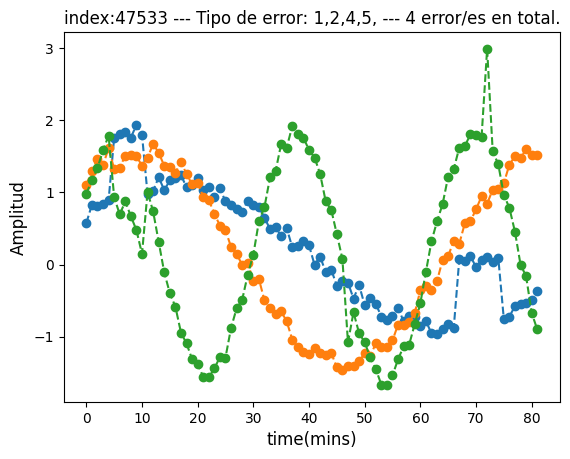

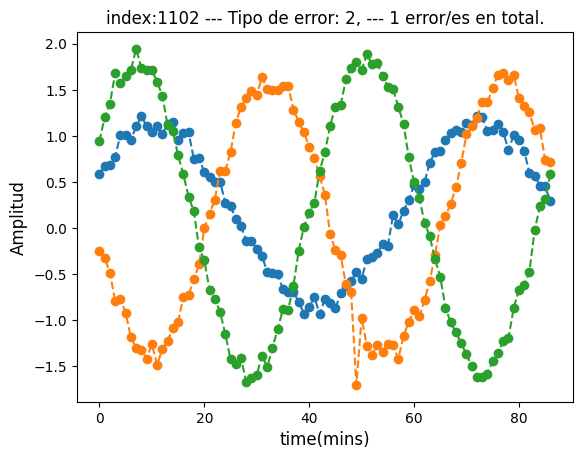

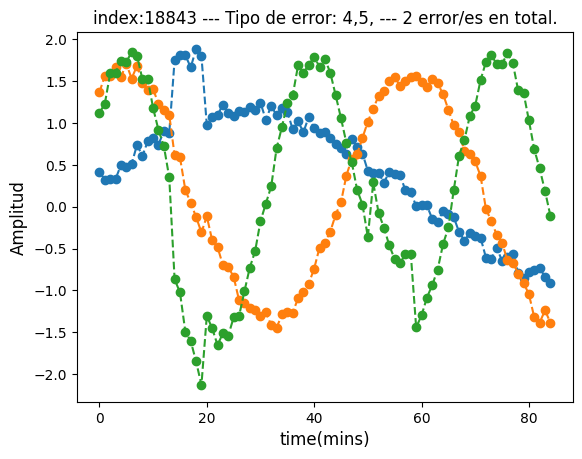

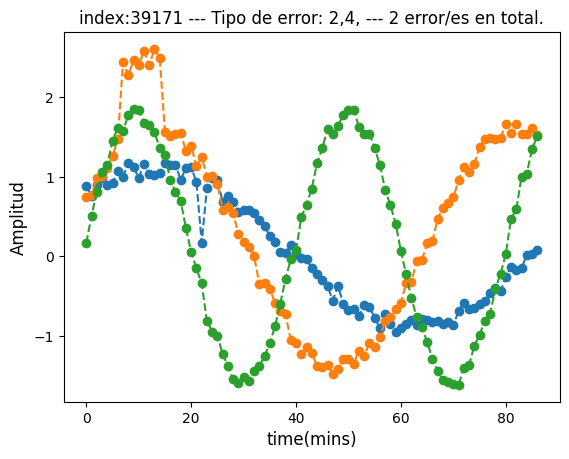

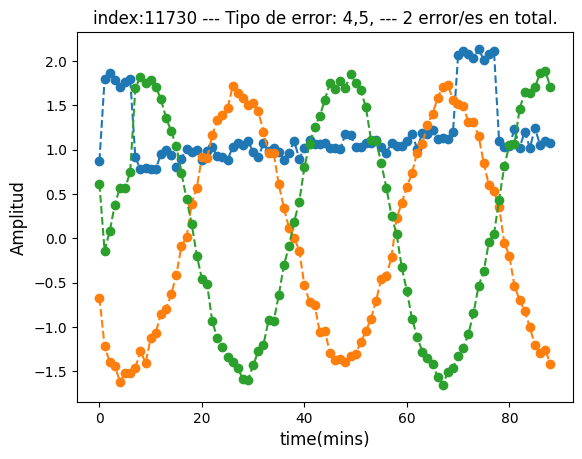

In [ ]:
def sensor_plotter(x,y,idx):
  plt.plot(x[idx], 'o--')
  title = 'index:' + str(idx) +' --- Tipo de error: '
  errors_idx = np.where(y[idx] == True)[0]
  if len(errors_idx)>0:
    for class_idx in errors_idx:
      title += str(class_idx+1)+','  
  else:
    title += 'None ' 
  title += ' --- '+str(len(errors_idx))+' error/es en total.'
  plt.title(title)
  plt.xlabel('time(mins)', fontsize=12)
  plt.ylabel('Amplitud', fontsize=12)
  plt.show()

rand_range = np.random.randint(len(xl), size=5)
for i in rand_range:
    sensor_plotter(xl,yl,i)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Describe los datos</strong>: tipo de funciones, diferentes tipos de errores que puedas identificar, etc...</p>
<p>(Añade tus comentarios substituyendo este texto)</p>
</div>

## 1.3 Estadísticos sobre los datos

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Realiza un estudio estadístico básico de los datos:</p>
  <ul>
    <li> Convierte los labels booleanos en numéricos <code>False -> 0.</code> y <code>True -> 1.</code>. </li>
    <li>Probabilidad de aparición de cada tipo de error. Haz un histograma para la clase con menor probabilidad de aparición.</li>
    <li>Longitud media, máxima y mínima de las lecturas de los sensores. Haz un histograma para las longitudes y determina que tipo de distribución genera las diferentes logitudes en las lecturas de los sensores.</li>
  </ul>
</div>

In [ ]:
y = np.array(yl, dtype = float)
y_len=np.shape(y)[0]

In [ ]:
counts = np.count_nonzero(y, axis=0)/y_len
counts

array([0.17832596, 0.26935775, 0.10191242, 0.32681326, 0.45816981])

([<matplotlib.axis.XTick at 0x7f94c5e06d90>,
 [Text(0, 0, 'False'), Text(1, 0, 'True')])

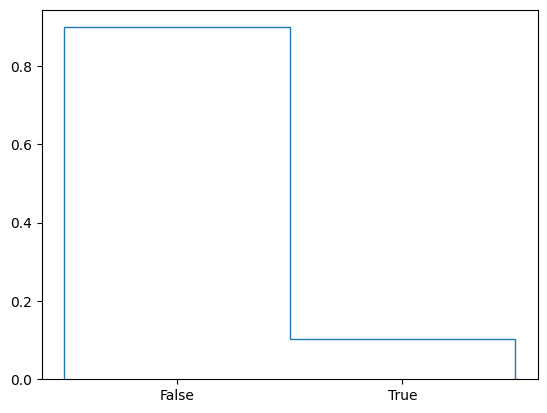

In [ ]:
plt.hist(y.transpose()[2],bins=np.arange(3) - 0.5, histtype="step", density=True)
plt.xticks(np.arange(2),['False','True'])

avg_length:  90
min_length: 78
max_length: 101


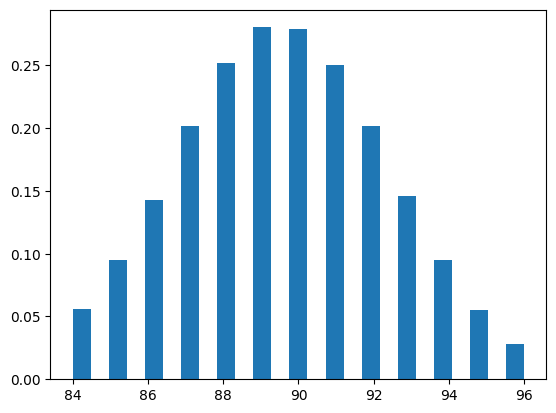

In [ ]:
lengths = [sensor_read.shape[0] for sensor_read in xl]
avg_length = round(np.mean(lengths))
print('avg_length: ',avg_length)
min_length = round(np.min(lengths))
print('min_length:', min_length)
max_length = round(np.max(lengths))
print('max_length:', max_length)
plt.hist(lengths, bins = 25, range=(84, 96), histtype="bar", density=True)
plt.show()

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comentarios:</strong></p>
<p>(Añade tus comentarios substituyendo este texto)</p>
</div>

## 1.4 Uniformizando la longitud de los datos

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Dado que las lecturas de los sensores tiene longitudes variables, necesitamos estandarizarlas. Para esta sección, hay varias opciones pero empezaremos por la más sencilla:</p>
  <ul>
    <li>Las lecturas con tiempos mayores a la media, las cortaremos.</li>
    <li>Las lecturas con medias menores a las medias, las completaremos con el valor médio de cada sensor.</li>
  </ul>
<p>Después de este proceso, elige un caso de tiempo mayor y uno menor y visualizalos usando la función <code>sensor_plotter</code>.</p>
</div>

In [ ]:
x = []
for sensor_read in xl:
    length = sensor_read.shape[0]
    if length < avg_length:
        mean_for_each_sensor  = sensor_read.mean(axis = 0)[np.newaxis]
        new_data = np.repeat(mean_for_each_sensor, avg_length - length, axis = 0)
        x.append(np.concatenate([sensor_read, new_data], axis = 0))
    else:
        x.append(sensor_read[:avg_length])
x = np.array(x)

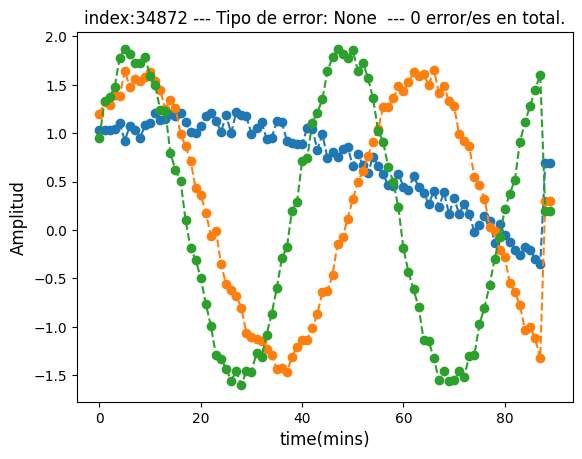

In [ ]:
sensor_plotter(x,yl,34872)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comenta que tipo de problemas puede conllevar este proceso</strong>. ¿Propondrías otro método para uniformizar los datos?</p>
<p>(Añade tus comentarios substituyendo este texto)</p>
</div>

In [ ]:
# Indica las dimensiones de los datos y los labels
print(x.shape, y.shape)

(48159, 90, 3) (48159, 5)


## 1.5 Data split para clasificación

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Antes de empezar con la construcción de un modelo de clasificación, realizaremos una partición (split) de los datos en 3 grupos:</p>
  <ul>
    <li> 80% para entrenamiento: <code>x_train</code></li>
    <li> 10% para validacion: <code>x_val</code></li>
    <li> 10% para testeo <code>x_test</code></li>
  </ul>
<p>y un <i>shuffle</i> de cada conjunto.</p>
</div>

In [ ]:
train_per = 0.8
val_per = 0.1

x_len = len(x) 
n_for_train = int(train_per * x_len)
n_for_val = int((train_per + val_per) * x_len)

# _Shuffle
idx = np.arange(x_len)
np.random.shuffle(idx)

x_train, y_train = x[idx[:n_for_train]], y[idx[:n_for_train]]
x_val, y_val = x[idx[n_for_train:n_for_val]], y[idx[n_for_train:n_for_val]]
x_test, y_test = x[idx[n_for_val:]], y[idx[n_for_val:]]

# 2. Clasificación (3 puntos)

El primer paso será definir las dimensiones de los datos de entrada en los modelos

In [ ]:
# Definimos el número de sensores de los que disponemos y el número de clases (tipos de errores)
nSensores = x[0].shape[1]
nClases = len(y[0])

## 2.1 Callbacks

Una vez tenemos los datos preparados y entendemos mejor el conjunto de datos del que disponemos, podemos empezar a testear diferentes arquitecturas para la clasificación de los tipos de errores. 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Primero, crearemos un callback propio para conocer el tiempo utilizado en el entrenamiento ya que lo usaremos también como métrica a la hora de escoger la arquitectura final de la red de clasificación.</p>
</div>

In [ ]:
class TimerCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

Además, usaremos la siguiente clase para visualizar las métricas durante el _fit_ de los modelos:

In [ ]:
#------------------------------#
#     NO TOCAR ESTA CLASE      #
#------------------------------#

class PlotLearning(Callback):
    """
    Callback para plotear las métricas durante el entrenamiento.
    """
    def __init__(self, showLR=False):
      self.showLR = showLR                   # podemos elegir si mostrar o no el plot del learning rate en cada epoch

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        metric = [x for x in logs if ('val' not in x) and ('lr' not in x)]
        if self.showLR:
          metric.append('lr')
        
        f, axs = plt.subplots(1,len(metric),figsize=(10,4))
        clear_output(wait=True)
        for i,ax in enumerate(axs):
          ax.plot(range(1, epoch + 2), self.metrics[metric[i]],'o--',label=metric[i])
          try:
            ax.plot(range(1, epoch + 2), self.metrics['val_' + metric[i]], 'o--', label='val_' + metric[i])
          except:
            pass
          ax.set_xlabel('# epochs')
          ax.set_ylabel(metric[i])
          ax.legend()
          ax.grid()

        plt.tight_layout()
        plt.show()

## 2.2 SimpleRNN Layer

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> El primer paso será construir un modelo, <code>simpleRNN_model</code>, basado en un único _layer_ <code>SimpleRNN</code> para tener un primer modelo base con el que comparar:</p>
  <ul>
    <li><code>SimpleRNN</code> con <code>units = 128</code>.</li>
    <li>La capa final será una cada densa con tantos nodos como clases tenemos.</li>
  </ul>
<p>El output de la capa densa la interpretaremos como una probabilidad, por lo que es necesario escoger correctamente la función de activación y justificar su elección. Además, utilizaremos <code>Adam</code> como optimizador y la función de <i>loss</i> deberá ser la adecuada teniendo en cuenta la tarea que llevamos a cabo.</p>
</div>

**NOTA**: 
- Se recomienda, al final de la creación de cada modelo, utilizar la función `summary()` para comprobar la estructura de la red creada, así como el numero de parámetros que se deben entrenar. Se recomienda hacerlo en todos los ejercicios.

In [ ]:
simpleRNN_model = Sequential(name='simpleRNN_model')
simpleRNN_model.add(SimpleRNN(128, input_shape = (None, nSensores), return_sequences = False))
simpleRNN_model.add(Dense(nClases, 'sigmoid'))

In [ ]:
loss = 'binary_crossentropy'
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
metric1 = tf.keras.metrics.BinaryAccuracy()

simpleRNN_model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=[metric1])

In [ ]:
simpleRNN_model.summary()

Model: "simpleRNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 128)               16896     
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                                 
Total params: 17,541
Trainable params: 17,541
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong>  Entrenaremos por 100 epochs con <code>batch_size = 256</code> y usando los siguientes callbacks:</p>
  <ul>
    <li>  TimerCallback (ver apartado 2.1)</li>
    <li>  PlotLearning (ver apartado 2.1)</li>
    <li>  EarlyStopping con una persistencia de 5 epochs</li>
    <li>  ReduceLROnPlateau con una persistencia de 5 epochs y monitorizando la <code>loss</code></li>
  </ul>
<p>Al finalizar el entreamiento:</p>
<ul>
    <li>  Realizar la evaluación del modelo y mostrar la <code>loss</code> y la <code>accuracy</code> final sobre los datos de test.</li>
    <li>  Realiza un plot del tiempo para cada epoch y calcula el tiempo total de entrenamiento con la información almacenada en el <code>TimerCallback</code> que has definido. </li>
  </ul>
</div>

**NOTAS**: 
- Se recomienda hacer una función que imprima esta gráfica para poder reutilizarla en próximos apartados.***
- Se recomienda SIEMPRE guardar los modelos una vez entrenados, pero es muy importante si trabajáis con entornos como Colab que os cierra las sesiones.
- Los timepos los necesitaremos luego, por lo que puede ser una buena idea también guardar los resultados de tiempos para cada epoch.

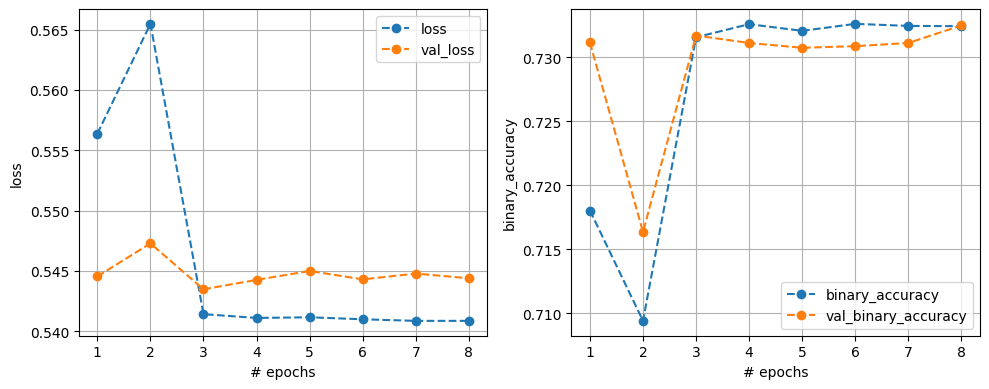

151/151 [==============================] - 6s 43ms/step - loss: 0.5409 - binary_accuracy: 0.7324 - val_loss: 0.5444 - val_binary_accuracy: 0.7325 - lr: 0.0010


In [ ]:
#parámetros de entrenamiento
epochs = 100
batch_size = 256

#callbacks
time_cb_simpleRNN = TimerCallback()
plotter_cb = PlotLearning(showLR = False)
early = EarlyStopping(patience = 5)
reduce = ReduceLROnPlateau(monitor = 'loss', patience = 5)

simpleRNN_model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = epochs, batch_size = batch_size, callbacks = [early, reduce, time_cb_simpleRNN, plotter_cb])
simpleRNN_model.save(home+'models/simpleRNN_model.h5')

In [ ]:
simpleRNN_model.evaluate(x_test, y_test)

151/151 [==============================] - 2s 10ms/step - loss: 0.5409 - binary_accuracy: 0.7339


[0.5409225225448608, 0.7339285612106323]

Tiempo total:  50.4 s


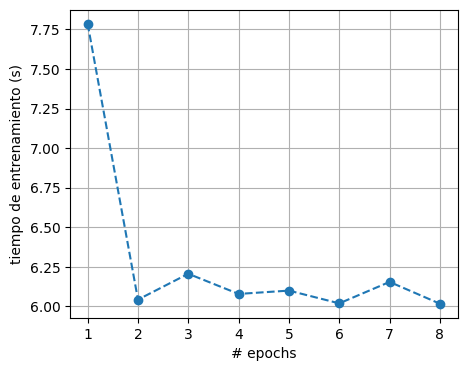

In [ ]:
def time_ploter(data, label=''):
  f, ax = plt.subplots(1,figsize=(5,4))
  ax.plot(range(1, len(data) + 1),data ,'o--',label=label)
  ax.set_xlabel('# epochs')
  ax.set_ylabel('tiempo de entrenamiento (s)')
  if label != '':
    ax.legend()
  ax.grid()
  f.show()


time_ploter(time_cb_simpleRNN.logs)
print('Tiempo total: ', round(sum(time_cb_simpleRNN.logs),2), 's')
np.savetxt(home+'/models/time_cb_simpleRNN.csv', time_cb_simpleRNN.logs, delimiter=',')

## 2.3 GRU layer

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong>  En este apartado replicaremos el modelo anterior, pero ahora cambiando el layer <code>SimpleRNN</code> por un layer <code>GRU</code> para comparar el rendimiento y el tiempo de entrenamiento. En este caso utilizaremos 64 unidades en lugar de 128 para mantener el número de parámetros y el tiempo de entrenamiento bajos.</p>
<p>Comenta los resultados:</p>
<ul>
    <li>  ¿Mejora el rendimiento general?</li>
    <li>  ¿Aumenta el tiempo de entrenamiento? ¿Y el número de parámetros entrenables?</li>
    <li>  ¿Cúal funciona mejor? ¿Por qué crees que sucede esto?</li>
  </ul>
</div>

In [ ]:
# Definición del modelo
GRU_model = Sequential(name='GRU_model')
GRU_model.add(GRU(64, input_shape = (None, nSensores), return_sequences = False))
GRU_model.add(Dense(nClases, 'sigmoid'))
GRU_model.summary()

# Compilación del modelo
loss = 'binary_crossentropy'
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
metric1 = tf.keras.metrics.BinaryAccuracy()

GRU_model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=[metric1])

Model: "GRU_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 64)                13248     
                                                                 
 dense_6 (Dense)             (None, 5)                 325       
                                                                 
Total params: 13,573
Trainable params: 13,573
Non-trainable params: 0
_________________________________________________________________


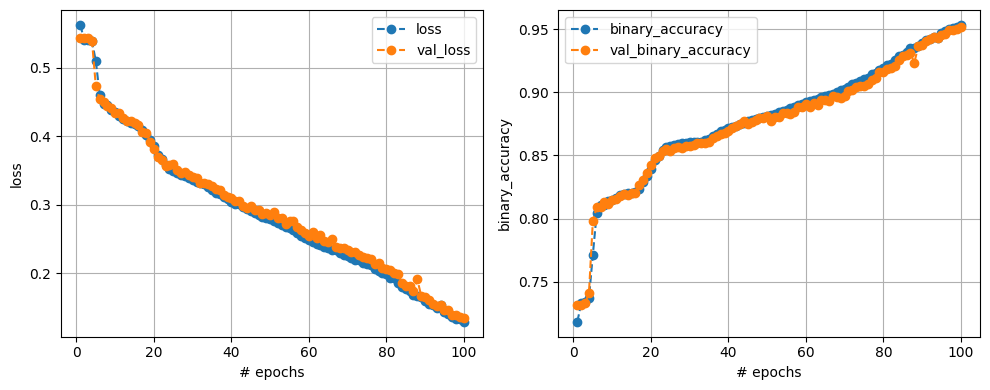

151/151 [==============================] - 1s 9ms/step - loss: 0.1286 - binary_accuracy: 0.9535 - val_loss: 0.1341 - val_binary_accuracy: 0.9517 - lr: 0.0010


In [ ]:
#callbacks
time_cb_GRU_model = TimerCallback()
plotter_cb = PlotLearning(showLR = False)
early = EarlyStopping(patience = 5)
reduce = ReduceLROnPlateau(monitor = 'loss', patience = 5)

GRU_model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = epochs, batch_size = batch_size, callbacks = [early, reduce, time_cb_GRU_model, plotter_cb])
GRU_model.save(home+'models/GRU_model.h5')

In [ ]:
GRU_model.evaluate(x_test, y_test)

151/151 [==============================] - 0s 3ms/step - loss: 0.1370 - binary_accuracy: 0.9517


[0.13703228533267975, 0.9517441987991333]

Tiempo total:  103.87 s


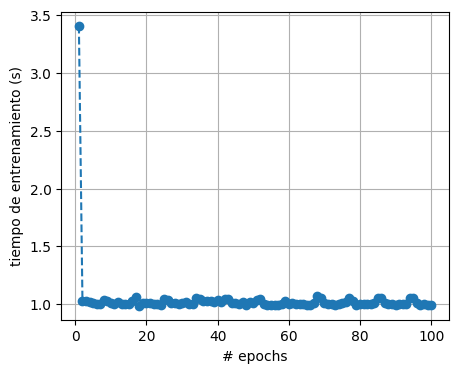

In [ ]:
time_ploter(time_cb_GRU_model.logs)
print('Tiempo total: ', round(sum(time_cb_GRU_model.logs),2), 's')
np.savetxt(home+'/models/time_cb_GRU_model.csv', time_cb_GRU_model.logs, delimiter=',')

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comentarios:</strong></p>
<p>(Añade tus comentarios substituyendo este texto)</p>
</div>

### 2.3.1 Incrementando la capacidad de nuestro modelo

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong>En esta sección intentaremos incrementar la capacidad de nuestro modelo y, para ello, en lugar de añadir unidades, aumentaremos la profundidad, sumando otra capa GRU. Esta nueva capa recibirá la sequencia de la capa anterior y tendrá la mitad de unidades.</p>
    <p>Comenta los resultados de rendimiento en <i>accuracy</i> y en tiempo.</p>
</div>

In [ ]:
GRU_model2 = Sequential(name='GRU_model2')
GRU_model2.add(GRU(64, input_shape = (None, nSensores), return_sequences = True))
GRU_model2.add(GRU(32, return_sequences = False))
GRU_model2.add(Dense(nClases, 'sigmoid'))
GRU_model2.summary()

# Compilación del modelo
loss = 'binary_crossentropy'
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
metric1 = tf.keras.metrics.BinaryAccuracy()

GRU_model2.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=[metric1])

Model: "GRU_model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, None, 64)          13248     
                                                                 
 gru_5 (GRU)                 (None, 32)                9408      
                                                                 
 dense_7 (Dense)             (None, 5)                 165       
                                                                 
Total params: 22,821
Trainable params: 22,821
Non-trainable params: 0
_________________________________________________________________


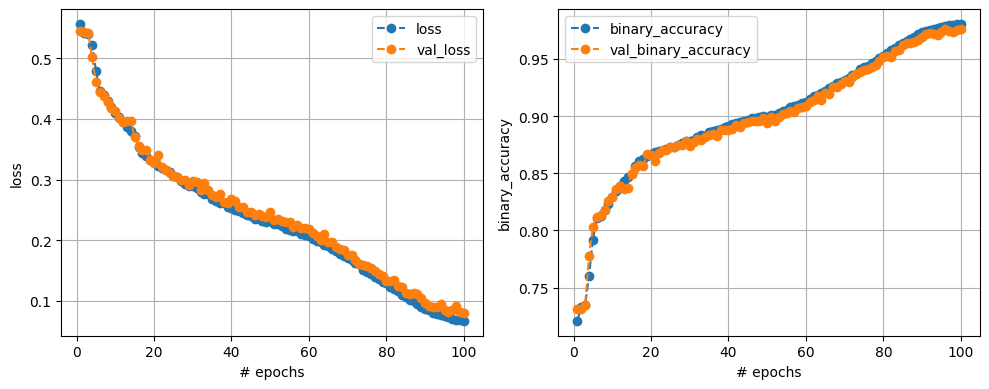

151/151 [==============================] - 2s 13ms/step - loss: 0.0672 - binary_accuracy: 0.9807 - val_loss: 0.0807 - val_binary_accuracy: 0.9761 - lr: 0.0010


In [ ]:
#callbacks
time_cb_GRU_model2 = TimerCallback()
plotter_cb = PlotLearning(showLR = False)
early = EarlyStopping(patience = 5)
reduce = ReduceLROnPlateau(monitor = 'loss', patience = 5)

GRU_model2.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = epochs, batch_size = batch_size, callbacks = [early, reduce, time_cb_GRU_model2, plotter_cb])
GRU_model2.save(home+'models/GRU_model2.h5')

In [ ]:
GRU_model2.evaluate(x_test, y_test)

151/151 [==============================] - 1s 5ms/step - loss: 0.0811 - binary_accuracy: 0.9767


[0.0811111181974411, 0.9766611456871033]

Tiempo total:  156.74 s


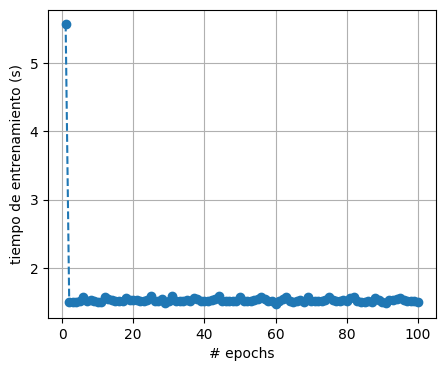

In [ ]:
time_ploter(time_cb_GRU_model2.logs)
print('Tiempo total: ', round(sum(time_cb_GRU_model2.logs),2), 's')
np.savetxt(home+'/models/time_cb_GRU_model2.csv', time_cb_GRU_model2.logs, delimiter=',')

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comentarios:</strong></p>
<p>(Añade tus comentarios substituyendo este texto)</p>
</div>

## 2.4 LSTM vs. GRU

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong>   
Sabemos que otro tipo de capa utilizada para las series temporales son las LSTM. En esta sección probaremos esta arquitectura y la compararemos con la anterior, para ver si es posible mejorar en rendimiento (<code>accuracy</code>) y/o en el tiempo de entrenamiento. Para ello, utilizaremos las mismas unidades en 2 capas de LSTM y entrenaremos de la misma forma la red. </p>
</div>

In [ ]:
LSTM_model = Sequential(name='LSTM_model')
LSTM_model.add(LSTM(64, input_shape = (None, nSensores), return_sequences = True))
LSTM_model.add(LSTM(32, return_sequences = False))
LSTM_model.add(Dense(nClases, 'sigmoid'))
LSTM_model.summary()

# Compilación del modelo
loss = 'binary_crossentropy'
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
metric1 = tf.keras.metrics.BinaryAccuracy()

LSTM_model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=[metric1])

Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, None, 64)          17408     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dense_9 (Dense)             (None, 5)                 165       
                                                                 
Total params: 29,989
Trainable params: 29,989
Non-trainable params: 0
_________________________________________________________________


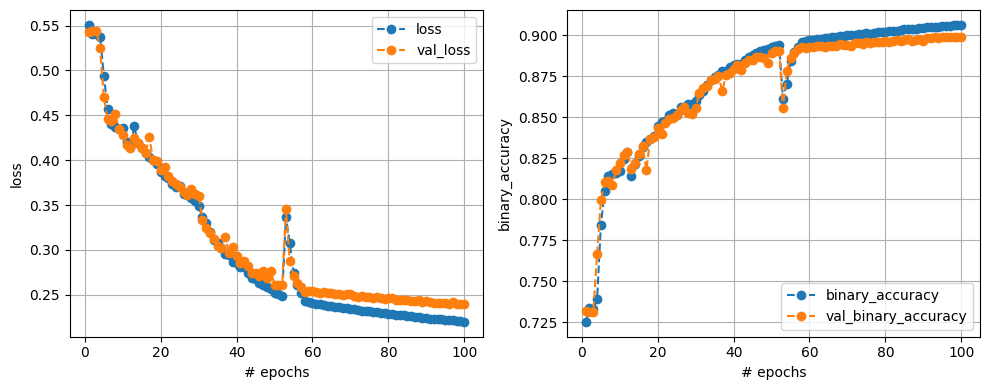

151/151 [==============================] - 2s 14ms/step - loss: 0.2198 - binary_accuracy: 0.9064 - val_loss: 0.2401 - val_binary_accuracy: 0.8989 - lr: 1.0000e-04


In [ ]:
#callbacks
time_cb_LSTM_model = TimerCallback()
plotter_cb = PlotLearning(showLR = False)
early = EarlyStopping(patience = 5)
reduce = ReduceLROnPlateau(monitor = 'loss', patience = 5)

LSTM_model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = epochs, batch_size = batch_size, callbacks = [early, reduce, time_cb_LSTM_model, plotter_cb])
LSTM_model.save(home+'models/LSTM_model.h5')

In [ ]:
LSTM_model.evaluate(x_test, y_test)

151/151 [==============================] - 1s 5ms/step - loss: 0.2318 - binary_accuracy: 0.9021


[0.23182062804698944, 0.9021179676055908]

Tiempo total:  167.67 s


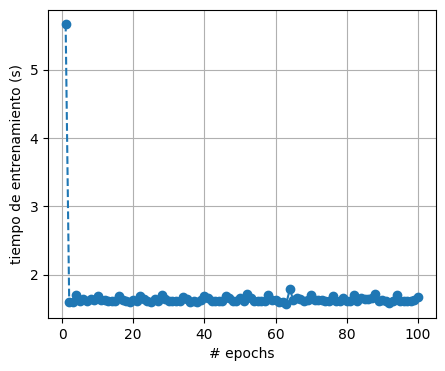

In [ ]:
time_ploter(time_cb_LSTM_model.logs)
print('Tiempo total: ', round(sum(time_cb_LSTM_model.logs),2), 's')
np.savetxt(home+'/models/time_cb_LSTM_model.csv', time_cb_LSTM_model.logs, delimiter=',')

# 3. Elección del mejor modelo y *fine tuning* (2 puntos)

En el apartado anterior ya hemos probado varios tipos de modelos diferentes. Ahora, basados en el rendimiento, complejidad (número de parámetros) y tiempo de entrenamiento, debemos escoger el tipo de modelo que mejor se adecua a nuestro problema. 

## 3.1 Comparación de modelos

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]</strong>: Realiza y responde las siguientes cuestiones:</p>
  <ul>
    <li>Haz una tabla comparativa para todos los modelos y arquitecturas usadas comparando el rendimiento, el número de parámetros y el tiempo por época (time/epoch)</li>
    <li>Justifica la elección de un modelo</li>
  </ul>
</div>

In [ ]:
# Recuperamos los modelos
LSTM_model = load_model(home+'models/LSTM_model.h5')
GRU_model2 = load_model(home+'models/GRU_model2.h5')
GRU_model = load_model(home+'models/GRU_model.h5')
simpleRNN_model = load_model(home+'models/simpleRNN_model.h5')

# Recuperamos los vectores de tiempos de cada modelo
time_LSTM_model =  np.loadtxt(home+'/models/time_cb_LSTM_model.csv', delimiter=',')
time_GRU_model2 =  np.loadtxt(home+'/models/time_cb_GRU_model2.csv', delimiter=',')
time_GRU_model =  np.loadtxt(home+'/models/time_cb_GRU_model.csv', delimiter=',')
time_simpleRNN =  np.loadtxt(home+'/models/time_cb_simpleRNN.csv', delimiter=',')

# Calculamos la accuracy
acc_simpleRNN_model = simpleRNN_model.evaluate(x_test, y_test)[1]
acc_GRU_model = GRU_model.evaluate(x_test, y_test)[1]
acc_GRU_model2 = GRU_model2.evaluate(x_test, y_test)[1]
acc_LSTM_model = LSTM_model.evaluate(x_test, y_test)[1]

accs = [acc_simpleRNN_model,acc_GRU_model,acc_GRU_model2,acc_LSTM_model]

# Número de parámetros
num_params_simpleRNN_model = simpleRNN_model.count_params()
num_params_GRU_model = GRU_model.count_params()
num_params_GRU_model2 = GRU_model2.count_params()
num_params_LSTM_model = LSTM_model.count_params()

params = [num_params_simpleRNN_model,num_params_GRU_model,num_params_GRU_model2,num_params_LSTM_model]

# Tiempo por epoca para el entrenamiento
time_per_epoch_simpleRNN =  round(sum(time_simpleRNN)/len(time_simpleRNN),2)
time_per_epoch_GRU_model =  round(sum(time_GRU_model)/len(time_GRU_model),2)
time_per_epoch_GRU_model2 =  round(sum(time_GRU_model2)/len(time_GRU_model2),2)
time_per_epoch_LSTM_model =  round(sum(time_LSTM_model)/len(time_LSTM_model),2)

times = [time_per_epoch_simpleRNN,time_per_epoch_GRU_model,time_per_epoch_GRU_model2,time_per_epoch_LSTM_model]

151/151 [==============================] - 1s 5ms/step - loss: 0.2318 - binary_accuracy: 0.9021


In [ ]:
from tabulate import tabulate

names = ['simpleRNN_model','GRU_model','GRU_model2','LSTM_model']
data = []

for name,acc,param,time in zip(names,accs,params,times):
  data.append([name,round(acc,3),param,time])

print (tabulate(data, headers=['Model', 'Acc.', 'Params.', 'Tiempo/epoch']))

Model              Acc.    Params.    Tiempo/epoch
---------------  ------  ---------  --------------
simpleRNN_model   0.734      17541            6.3
GRU_model         0.952      13573            1.04
GRU_model2        0.977      22821            1.57
LSTM_model        0.902      29989            1.68


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comentarios:</strong></p>
<p>(Añade tus comentarios substituyendo este texto)</p>
</div>

## 3.2 *Fine Tuning* de parámetros para el modelo elegido

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pt.]:</strong>  Para realizar una elección de parámetros que optimize los resultados utilizaremos la librería <code>keras-tuner</code>. El primer paso con una librería nueva es consultar la documentación y familiarizarse con ejemplos básicos.</p>
<p>Los parámetros que eligiremos para el ajuste son:</p>
  <ul>
    <li><strong>Unidades de la primera capa</strong>. Variarán entre 16 y 64 con steps de 16.</li>
    <li>Añadiremos <strong>dropout en la segunda capa</strong> y los valores serán: 0, 0.1, 0.25 y 0.7 </li>
    <li><strong>Learning rate</strong> que podrá tomar los siguientes valores: 1e-2, 5e-3 y 1e-3</li>
  </ul>
<p>Finalmente, usaremos el método de <code>Hyperband</code> cuyo objetivo será optimizar la <i>accuracy</i> de validación.</p>
</div>

In [ ]:
#------------------------------#
#    INSTALAMOS KERAS-TUNER    #
#------------------------------#

!pip install -q -U keras-tuner
import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 KB 6.4 MB/s eta 0:00:00


In [ ]:
def model_builder(hp):

  model = Sequential(name='model')


  hp_units1 = hp.Int('units', min_value=16, max_value=65, step=16)
  model.add(GRU(units=hp_units1, input_shape = (None, nSensores), return_sequences = True))

  hp_dropout = hp.Choice('dropout', values=[0., 0.1, 0.25, 0.7])
  model.add(GRU(units=32, return_sequences = False, dropout=hp_dropout))

  model.add(Dense(nClases, 'sigmoid'))
    
  loss = 'binary_crossentropy'
  
  # diferentes valores para el LR
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 5e-3, 1e-3])
  optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)

  metric1 = tf.keras.metrics.BinaryAccuracy()

  # Compilación del modelo
  model.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=[metric1])

  return model

tuner = kt.Hyperband(model_builder,
                     objective='val_binary_accuracy',
                     max_epochs=100,
                     factor=3,
                     overwrite=True,
                     directory=home,
                     project_name='GRU_best_model')

In [ ]:
#callbacks
tuner.search(x_train, y_train, epochs=2, validation_data=(x_val, y_val))
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 48 Complete [00h 00m 30s]
val_binary_accuracy: 0.8208056688308716

Best val_binary_accuracy So Far: 0.9636212587356567
Total elapsed time: 00h 23m 47s


In [ ]:
best_units = best_hps.get('units')
best_dropout = best_hps.get('dropout')
best_learning_rate = best_hps.get('learning_rate')

print('best_units:', best_units)
print('best_dropout:', best_dropout)
print('best_learning_rate:', best_learning_rate)

best_units: 64
best_dropout: 0.25
best_learning_rate: 0.005


## 3.3 Entrenamiento del modelo con los hiperparámetros tuneados

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong>Tal como hicimos en la sección 2 con otro modelos, entrena el modelo final para la clasificación durante 100 epochs usando los parámetros obtenidos en el apartado anterior, <code>EarlyStoping</code> con una <i>patience</i> de 5 epochs, pero ahora sin el callback para reducir el <i>learning rate</i>.</p>
<p>Calcula el <i>accuracy</i> sobre el grupo de test y el tiempo total de entrenamiento.</p>
</div>

In [ ]:
best_model = Sequential(name='best_model')
best_model.add(GRU(best_units, input_shape = (None, nSensores), return_sequences = True))
best_model.add(GRU(32, return_sequences = False, dropout=best_dropout))
best_model.add(Dense(nClases, 'sigmoid'))
best_model.summary()

Model: "best_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, None, 64)          13248     
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 22,821
Trainable params: 22,821
Non-trainable params: 0
_________________________________________________________________


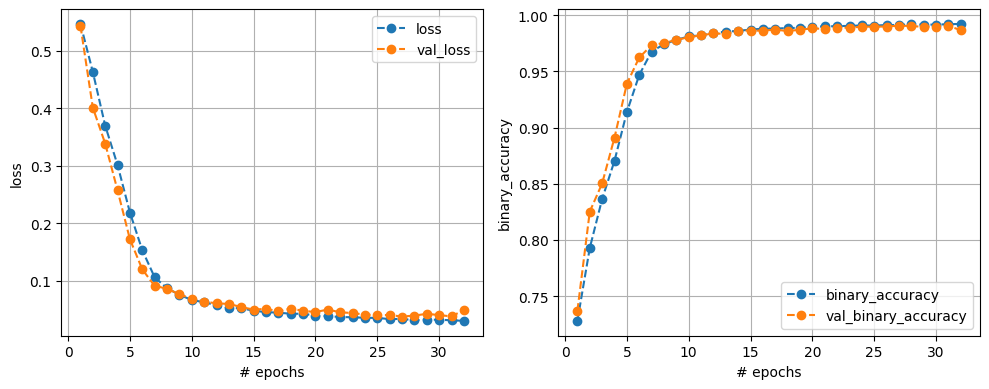

151/151 [==============================] - 2s 13ms/step - loss: 0.0303 - binary_accuracy: 0.9922 - val_loss: 0.0492 - val_binary_accuracy: 0.9865


In [ ]:
# Compilación del modelo
epochs = 100
batch_size = 256

loss = 'binary_crossentropy'
optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate)
metric1 = tf.keras.metrics.BinaryAccuracy()

best_model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=[metric1])

#callbacks
time_cb = TimerCallback()
plotter_cb = PlotLearning(showLR = False)
early = EarlyStopping(patience = 5)

best_model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = epochs, batch_size = batch_size, callbacks = [early, time_cb, plotter_cb])
best_model.save(home+'models/best_model.h5')

In [ ]:
best_model.evaluate(x_test, y_test)

151/151 [==============================] - 1s 5ms/step - loss: 0.0473 - binary_accuracy: 0.9869


[0.04731810837984085, 0.9869186282157898]

Tiempo total:  54.66 s


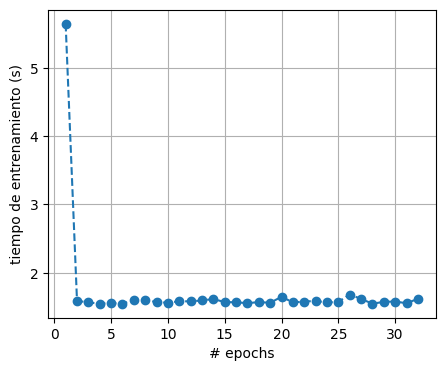

In [ ]:
time_ploter(time_cb.logs)
print('Tiempo total: ', round(sum(time_cb.logs),2), 's')

# 4. Localización de los errores (2,5 puntos)

## 4.1 Definiendo un nuevo modelo para la localización de los errores

Para encontrar cuándo ocurre un error en la lectura de un sensor, una secuencia determinada se dividirá en segmentos y la clasificación se realizará en cada segmento individualmente. Para ello, hay que definir un nuevo modelo que divida la señal de entrada y estas partes se le pasarán al siguiente _layer_ donde se usará el clasificador que ya hemos entrenado anteriormente.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1,5 pts.]:</strong>  Definir un nuevo modelo que constará de las siguientes capas (layers): </p>
  <ul>
    <li>  <code>Reshape</code> para cortar la entrada en sub-secuencias de 10 </li>
    <li>  Una capa con el clasificador anterior <code>best_model</code></li>
    <li>  Una capa final que nos permita obtener el máximo de las capas anteriores y poder comparar con los datos de entrenamiento</li>
  </ul>
<p> Entrena este modelo por 100 epochs usando, como siempre, EarlyStoping. Comenta los resultados y si realmente tiene sentido volver a entrar con los mismos datos <code>x_train</code> de los que disponemos.</p>
</div>

In [ ]:
sub_seq_model = Sequential(name='sub_seq_model')
# Cortamos en sub-secuencias 10
sub_seq_model.add(Reshape((-1, 10, nSensores), input_shape = (None, nSensores)))
# Clasificamos cada sub-secuencia
sub_seq_model.add(TimeDistributed(best_model))
# Nos quedamos con el máximo de cada sub-secuencia para cada defecto
sub_seq_model.add(GlobalMaxPool1D())
sub_seq_model.compile(loss = 'binary_crossentropy', metrics = 'binary_accuracy')
sub_seq_model.summary()

Model: "sub_seq_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, None, 10, 3)       0         
                                                                 
 time_distributed (TimeDistr  (None, None, 5)          22821     
 ibuted)                                                         
                                                                 
 global_max_pooling1d (Globa  (None, 5)                0         
 lMaxPooling1D)                                                  
                                                                 
Total params: 22,821
Trainable params: 22,821
Non-trainable params: 0
_________________________________________________________________


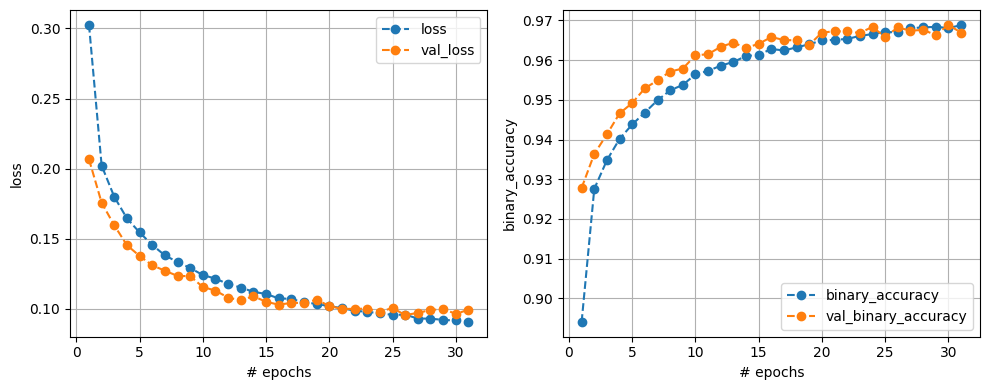

151/151 [==============================] - 1s 10ms/step - loss: 0.0906 - binary_accuracy: 0.9688 - val_loss: 0.0992 - val_binary_accuracy: 0.9669


In [ ]:
# Compilación del modelo
epochs = 100
batch_size = 256

loss = 'binary_crossentropy'
optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate)
metric1 = tf.keras.metrics.BinaryAccuracy()

sub_seq_model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=[metric1])

#callbacks
time_cb = TimerCallback()
plotter_cb = PlotLearning(showLR = False)
early = EarlyStopping(patience = 5)

sub_seq_model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = epochs, batch_size = batch_size, callbacks = [early, time_cb, plotter_cb])
sub_seq_model.save(home+'models/sub_seq_model.h5')

In [ ]:
sub_seq_model.evaluate(x_test, y_test)

151/151 [==============================] - 0s 3ms/step - loss: 0.1030 - binary_accuracy: 0.9673


[0.10300415009260178, 0.9672757387161255]

Tiempo total:  38.24 s


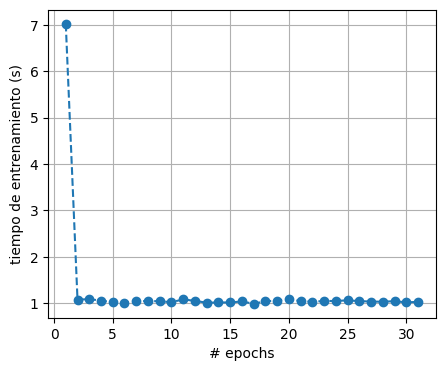

In [ ]:
time_ploter(time_cb.logs)
print('Tiempo total: ', round(sum(time_cb.logs),2), 's')

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comenta, además, que efectos tiene en la localización el hecho de hacer un reshape para tener N=10 sub-secuencias. Si hubieramos elegido N=1, 2 o 5, ¿qué cambiaría? </strong></p>
<p>(Añade tus comentarios substituyendo este texto)</p>
</div>

## 4.2 Modelo de localización de errores

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> El modelo anterior devuelve predicciones para la secuencia completa, pero para poder localizar los errores necesitaremos las predicciones para cada sub-secuencia y, por lo tanto, definiremos un nuevo modelo, <code>loc_model</code>, igual al anterior, pero obviando el último layer.</p>
<p>Explica el resultado obtenido usando un dato de test como ejemplo.</p>
</div>

In [ ]:
loc_model = Model(inputs = sub_seq_model.layers[0].input, outputs = sub_seq_model.layers[-2].output)
loc_model.summary()
loc_model.save(home+'models/loc_model.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_input (InputLayer)  [(None, None, 3)]         0         
                                                                 
 reshape (Reshape)           (None, None, 10, 3)       0         
                                                                 
 time_distributed (TimeDistr  (None, None, 5)          22821     
 ibuted)                                                         
                                                                 
Total params: 22,821
Trainable params: 22,821
Non-trainable params: 0
_________________________________________________________________


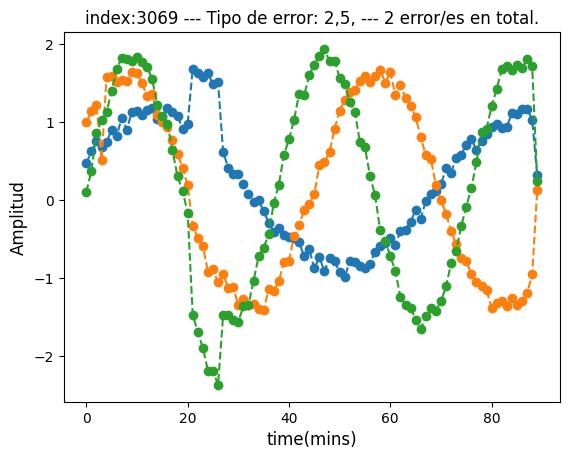

1/1 [==============================] - 1s 1s/step
[0. 1. 0. 0. 1.]
[[[0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]


In [ ]:
rand_range = np.random.randint(len(x_test), size=1)
for i in rand_range:
    sensor_plotter(x_test, y_test,i)
y_pred = loc_model.predict(x_test[i:i+1])
print(y_test[i])
print(np.round(y_pred))

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comentarios:</strong></p>
<p>(Añade tus comentarios substituyendo este texto)</p>
</div>

## 5. Visualización de los errores  (1 punto)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pt.]:</strong> Diseña una función que reciba una lectura de los sensores y su label, y que devuelva una gráfica con:</p>
    <ul>
    <li>  La lectura de los sensores.</li>
    <li>  Una banda vertical en la sub-secuencia donde se encuentra cada error. Habrá tantas bandas verticales como errores existan en la lectura.</li>
    <li>  Las bandas indicando errores deberán tener un color asociado a cada tipo de error y el <code>alpha</code> usado para pintar esa región será proporcional a la confianza en la clasificación de ese error.</li>
  </ul>
  <p>Además, informa de los errores detectados y los reales por pantalla. Usa esta función para visualizar 10 lecturas diferentes.</p>
</div>

In [ ]:
# Puedes usar estos colores para cada identificar los diferentes tipos de errores
color_errores = {1: 'tab:red', 2: 'tab:purple', 3: 'tab:brown', 4: 'tab:cyan', 5: 'tab:olive'}

1/1 [==============================] - 0s 27ms/step
Errores detectados: red olive
Errores reales: red olive


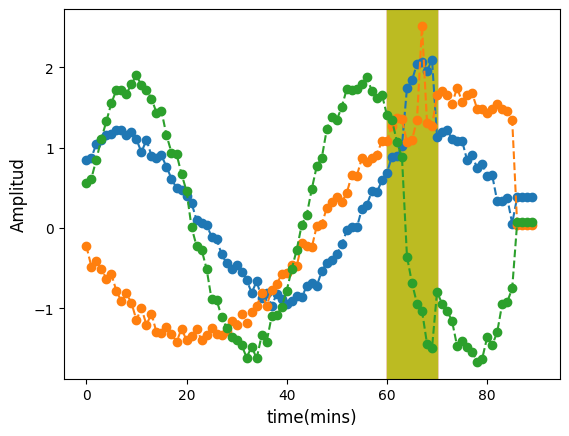

1/1 [==============================] - 0s 30ms/step
Errores detectados: cyan
Errores reales: cyan


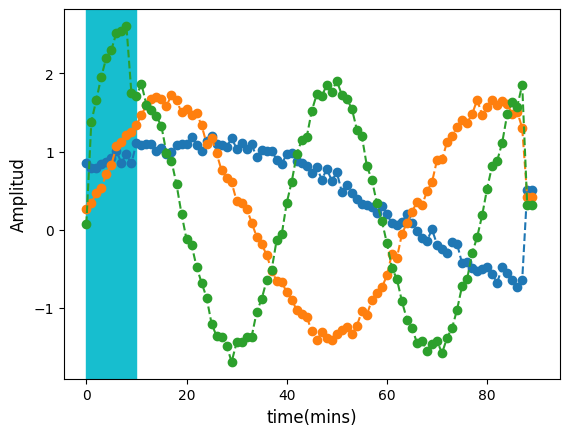

1/1 [==============================] - 0s 29ms/step
Errores detectados: purple
Errores reales: purple


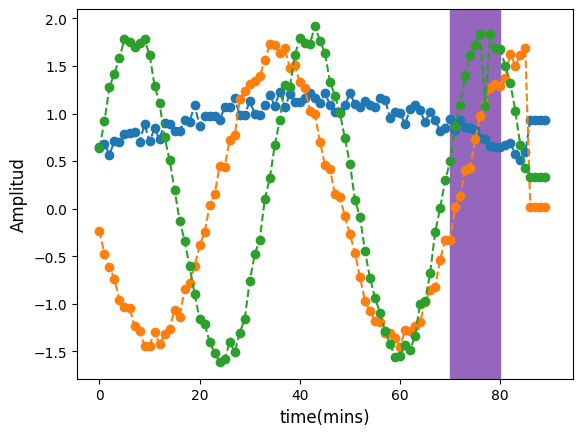

1/1 [==============================] - 0s 28ms/step
Errores detectados: olive
Errores reales: olive


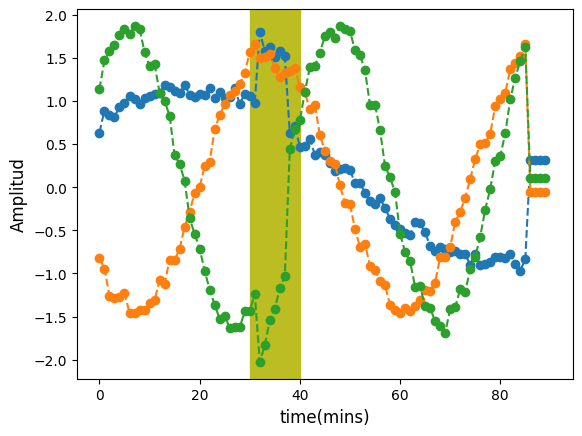

1/1 [==============================] - 0s 29ms/step
Errores detectados: cyan
Errores reales: cyan


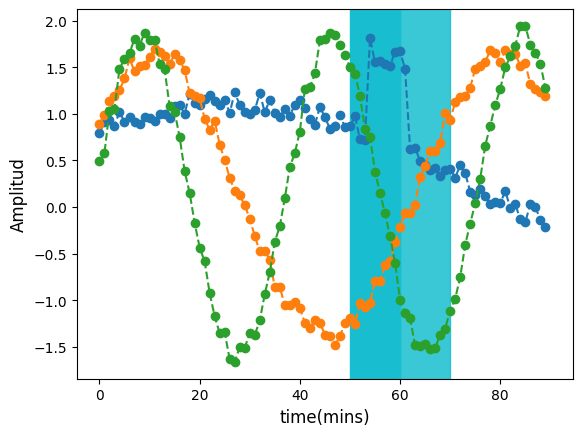

In [ ]:
def error_localization(idx):
  plt.plot(x_test[idx],'o--')
  plt.xlabel('time(mins)', fontsize=12)
  plt.ylabel('Amplitud', fontsize=12)

  # Buscamos los defectos
  errores = loc_model.predict(x_test[idx: idx + 1])

  # Los ordenamos como la probabilidad del error en cada subsecuencia
  errors_in_sequence = np.squeeze(errores).transpose()
  for i,error in enumerate(errors_in_sequence): # loop sobre los 5 tipos de errores
    for j,confidence in enumerate(error): # loop sobre las subsecuencias para un error dado 
      plt.axvspan(j*10, j*10+10, ymin = 0, ymax = 1, color = color_errores[i+1], alpha = confidence**2)

  # Comparamos la predicción contra los valores reales
  y_pred = np.amax(errores, axis = 1)[0]
  errores_detectados = ' '.join([color_errores[defect + 1].split(':')[1] for defect, occured in enumerate(y_pred) if occured > 0.3])
  print("Errores detectados: " + errores_detectados)
  errores_reales = ' '.join([color_errores[defect + 1].split(':')[1] for defect, occured in enumerate(y_test[idx]) if occured == 1])
  print("Errores reales: " + errores_reales)
  plt.show()

for sensor_read in np.random.randint(0, len(x_test), 5):
  error_localization(sensor_read)


# A eliminar

In [ ]:
loc_model = load_model(home+'models/loc_model.h5')
sub_seq_model = load_model(home+'models/sub_seq_model.h5')
best_model = load_model(home+'models/best_model.h5')
LSTM_model = load_model(home+'models/LSTM_model.h5')
GRU_model2 = load_model(home+'models/GRU_model2.h5')
GRU_model = load_model(home+'models/GRU_model.h5')
simpleRNN_model = load_model(home+'models/simpleRNN_model.h5')